# GOES16GeoTIFF

## In this notebook, we'll cover the following:
1. Read in a high-resolution raster file in GeoTIFF format that consists of multiple bands
2. Combine the bands into a single, true-color image and plot that image
3. Overlay the GeoTIFF on GeoAxes


# <span style="color:purple">0) Preliminaries

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import rioxarray as rio
import xarray as xr
import rasterio

# <span style="color:purple">1) Download, then read in a raster file in GeoTIFF format that consists of multiple bands </span>

In [2]:
rasURL = 'https://cdn.star.nesdis.noaa.gov/GOES16/ABI/FD/GEOCOLOR/GOES16-ABI-FD-GEOCOLOR-10848x10848.tif'
rasFile = 'goesLatest.tif'
!wget -O {rasFile} {rasURL}

--2021-06-10 19:48:50--  https://cdn.star.nesdis.noaa.gov/GOES16/ABI/FD/GEOCOLOR/GOES16-ABI-FD-GEOCOLOR-10848x10848.tif
Resolving cdn.star.nesdis.noaa.gov (cdn.star.nesdis.noaa.gov)... 140.90.107.146, 140.90.107.147
Connecting to cdn.star.nesdis.noaa.gov (cdn.star.nesdis.noaa.gov)|140.90.107.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 592283278 (565M) [image/tiff]
Saving to: ‘goesLatest.tif’

100%[======================================>] 592,283,278  111MB/s   in 5.1s   

2021-06-10 19:48:55 (110 MB/s) - ‘goesLatest.tif’ saved [592283278/592283278]



In [3]:
ras = rio.open_rasterio(rasFile)

#### We can see that the raster image has 4 bands.

In [4]:
ras

<xarray.DataArray (band: 4, y: 17000, x: 17000)>
[1156000000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * y            (y) float64 76.45 76.44 76.43 76.42 ... -76.48 -76.49 -76.49
  * x            (x) float64 -151.4 -151.4 -151.4 -151.4 ... 1.477 1.486 1.495
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

### Get the bounds of the raster file, since we need it for the `extent` argument in `imshow`.

In [5]:
ras.rio.bounds()

(-151.44970703125, -76.49930059814453, 1.4992929687500012, 76.44969940185547)

In [6]:
left,bottom,right,top = ras.rio.bounds()

In [7]:
cLon = (left + right) /2
cLon

-74.97520703125

### Get the resolution

In [8]:
ras.rio.resolution()

(0.008997, -0.008997)

#### That's horizontal resolution of less than .01 degrees!!

### Get the projection info.

In [9]:
ras.rio.crs

CRS.from_epsg(4326)

### This is actually not a projection, but instead describes the coordinate reference system (in this case, WGS84). The dataset itself has x- and y- coordinate values in degrees, so we can use PlateCarree as the map projection in Cartopy. We will also set a `Globe` object which defines the globe based on the raster file's attributes.

In [10]:
projCOG = ccrs.PlateCarree()

In [11]:
sMajAx = ras.spatial_ref.attrs['semi_major_axis']
sMinAx = ras.spatial_ref.attrs['semi_minor_axis']
invFlat = ras.spatial_ref.attrs['inverse_flattening']

Globe = ccrs.Globe(ellipse='WGS84',semimajor_axis = sMajAx, semiminor_axis = sMinAx,inverse_flattening=invFlat)

projNative = ccrs.PlateCarree(globe=Globe)

### Plot each of the bands directly from Xarray.

In [12]:
figSize = (15,15)

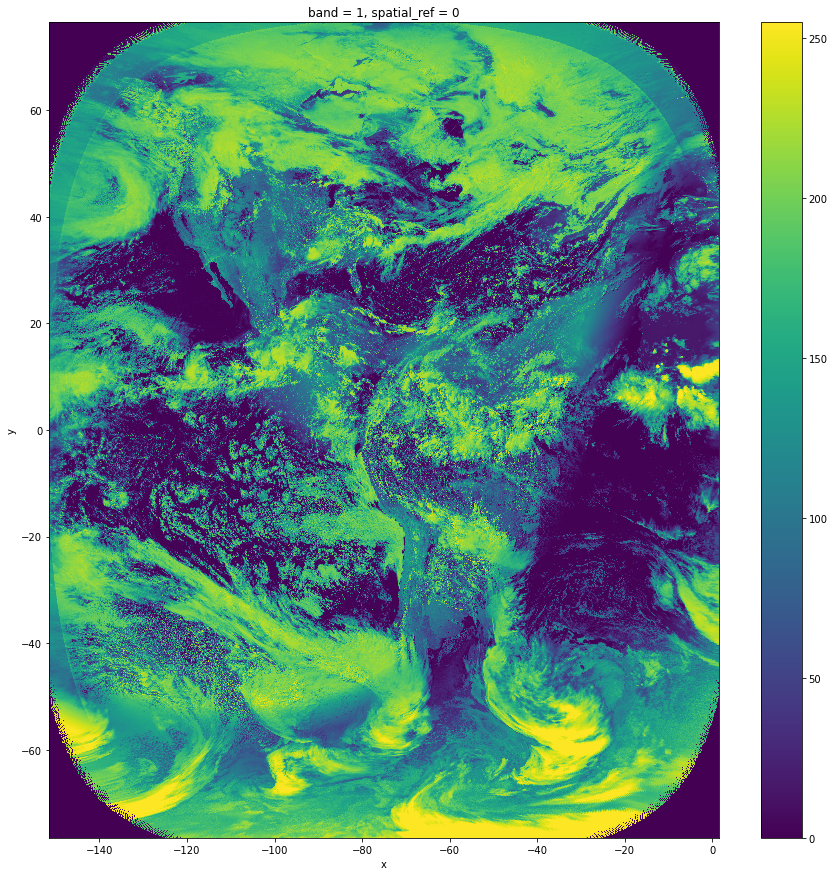

In [13]:
ras.sel(band=1).plot.imshow(figsize=figSize)

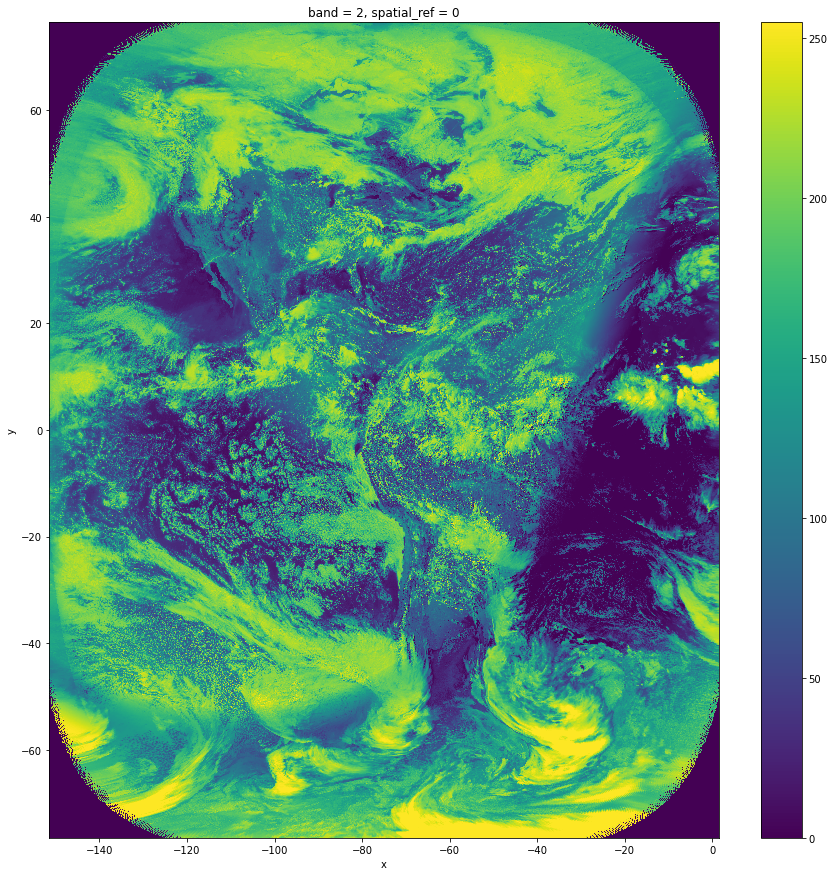

In [14]:
ras.sel(band=2).plot.imshow(figsize=figSize)

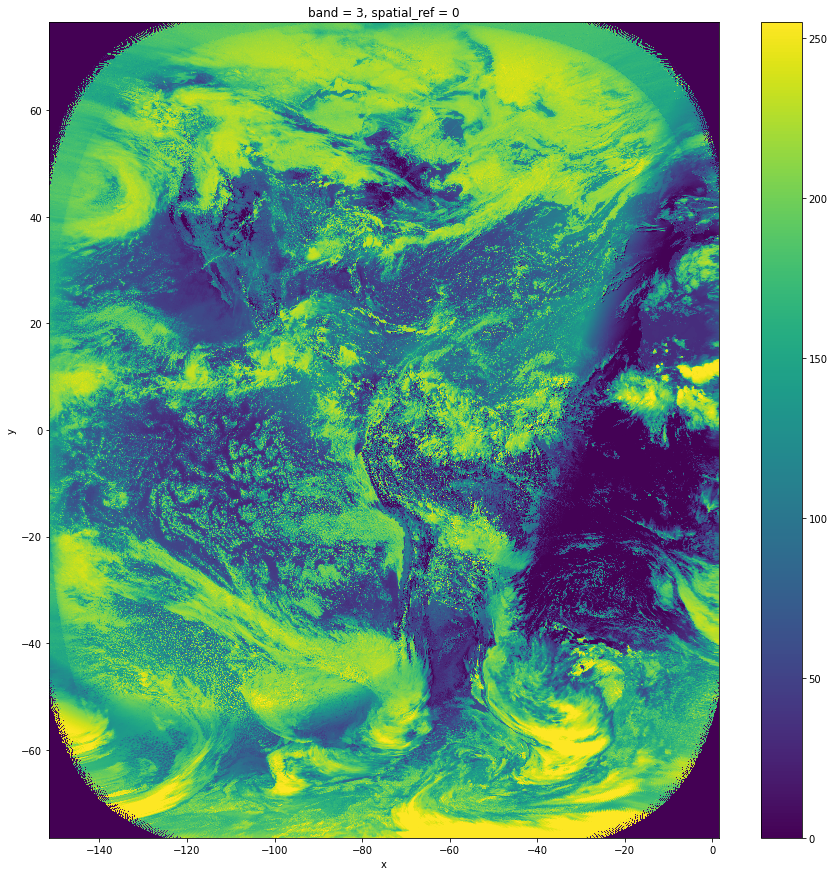

In [15]:
ras.sel(band=3).plot.imshow(figsize=figSize)


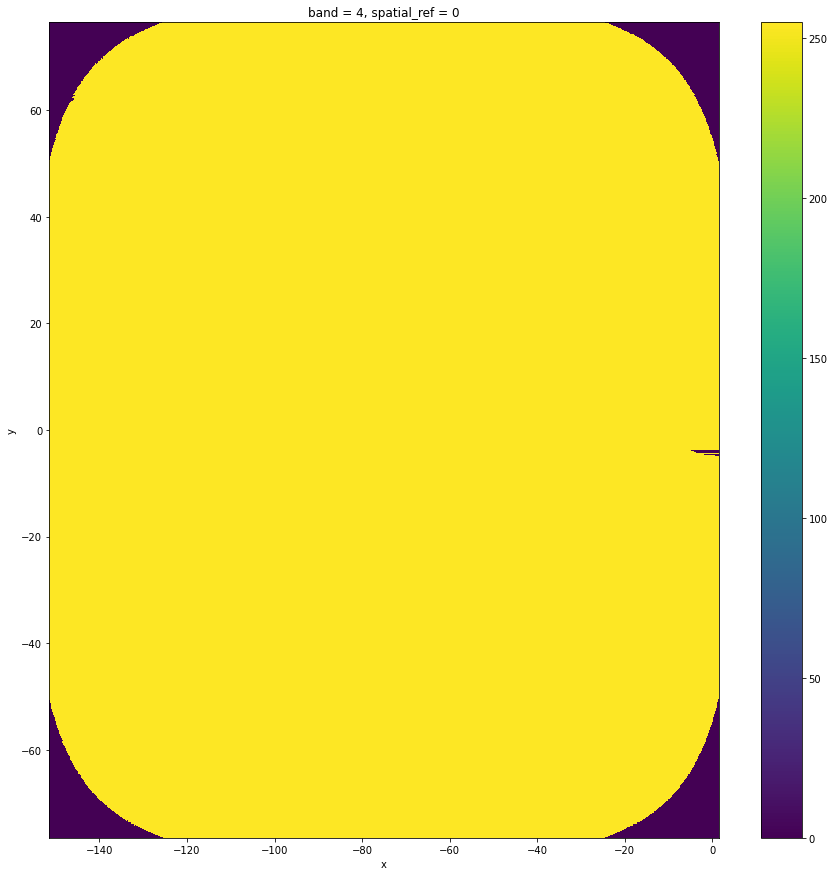

In [16]:
ras.sel(band=4).plot.imshow(figsize=figSize)


### Notice that a default colormap was used, and while we can certainly discern salient features of the underlying surface, the applied colors are deceptive. The four bands are actually red, green, blue, and alpha (transparency) pixel values. For this imagery, alpha = 0 signifies missing data.

#### Close this Xarray DataArray as we're done with it for now.

In [17]:
ras.close()

# <span style="color:purple">2) Combine the bands into a single, true-color image and plot that image</span> 

### We will now use the more general `rasterio` library to deal with combining these bands into a single image.

### Stack together the first 3 bands to arrive at a true-color composite image
References:
1. https://gis.stackexchange.com/questions/306164/how-to-visualize-multiband-imagery-using-rasterio
2. https://automating-gis-processes.github.io/CSC/notebooks/L5/plotting-raster.html
        

### By default, `rasterio` assumes that a GeoTIFF with 3 bands has a band order of red, green and blue (RGB). It interprets a 4-band image as *RGB/A*, where *A* denotes *alpha*, or transparency. Each of these four bands, or channels, have pixel values ranging from 0 to 255. For the three colors, the range goes from no color to saturated (full) color. For alpha, the range goes from completely transparent to completely opaque.
#### Rasterio's `colorinterp` method will display how it is characterizing each of these channels.

In [18]:
with rasterio.open(rasFile) as src:
    # convert / read the data into a numpy array:
    ras = src.read(masked= True)
    red = src.read(1)
    green = src.read(2)
    blue = src.read(3)
    print(src.colorinterp[0])
    print(src.colorinterp[1])
    print(src.colorinterp[2])
    print(src.colorinterp[3])
    
# view array shape -- notice that you have 3 dimensions below
print(ras.shape)

<ipython-input-18-eed7f6a55f00>:3: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  ras = src.read(masked= True)


ColorInterp.red
ColorInterp.green
ColorInterp.blue
ColorInterp.alpha
(4, 17000, 17000)


### We now normalize each of the three RGB bands so the ranges are from 0 to 1. We will ignore the alpha channel; for this GeoTIFF, alpha is set to 0 only for missing points, of which there are none.

In [19]:
# Normalization function
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

In [20]:
# Normalize bands
red_norm = normalize(red)
green_norm = normalize(green)
blue_norm = normalize(blue)

### Each of these are NumPy arrays; we can use NumPy's `dstack` function to create a single NumPy array that now has all three channels. This is known as a *true color* image.

<div class="admonition alert alert-warning">
    <p class="title" style="font-weight:bold">Warning</p>
    This next cell will be the most memory-intensive one, so be sure your system has sufficient RAM. For this 4x17000x17000 GeoTIFF, nearly 50 GB of RAM was used!
</div>

In [21]:
# Stack bands
rgb = np.dstack((red_norm, green_norm, blue_norm))

### Visualize this image. To start, we will not create geo-referenced Matplotlib axes with Cartopy ... the image is self-explanatory.

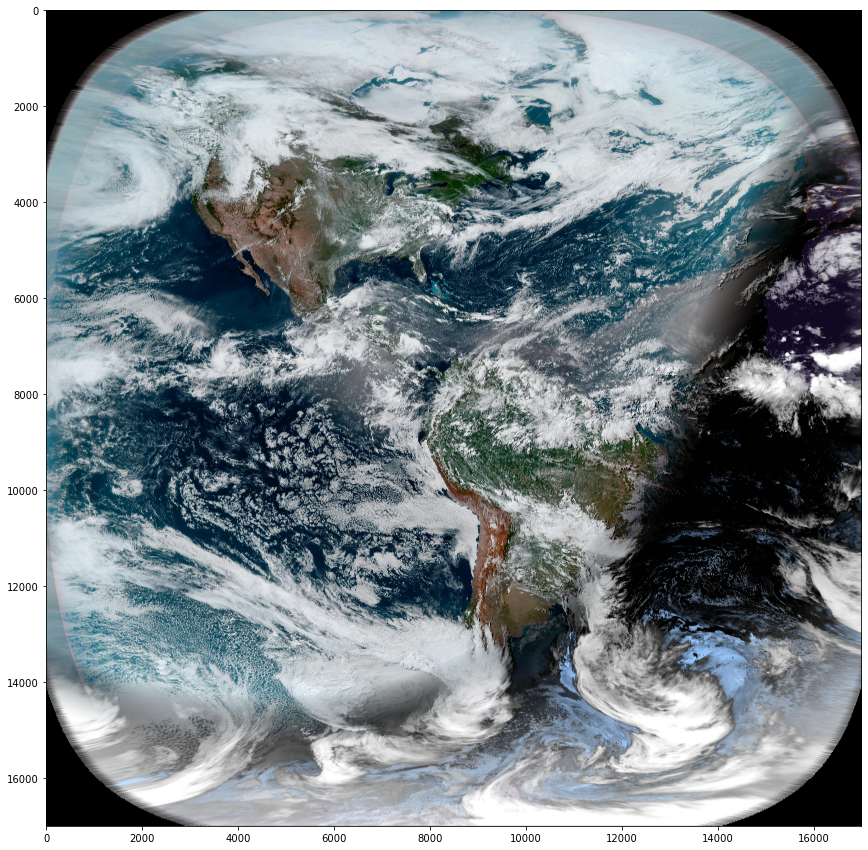

In [22]:
fig = plt.figure(figsize=(15,15))
plt.imshow(rgb)

# <span style="color:purple">3) Overlay the GeoTIFF on GeoAxes</span> 

### Now, let's plot this image on a set of GeoAxes. We'll use Cartopy's `Geostationary` projection, ideal for a satellite image such as this.

In [ ]:
res = '110m'
fig = plt.figure(figsize=(15,15))
ax = plt.subplot(1,1,1,projection=ccrs.Geostationary(globe=Globe,central_longitude=cLon))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.BORDERS.with_scale(res))
ax.add_feature (cfeature.STATES.with_scale(res))
im = ax.imshow(rgb,extent=[left, right, bottom, top],transform=ccrs.PlateCarree())

In [ ]:
fig.savefig('GOES.png')